# Synthetic seismic: wedge model

First, run through the notebook. Then try these challenges.

### Q. Try changing the rock properties.

### Q. Try plotting unresolved and resolved traces.

### Q. try using a different wavelet, e.g. spike, square, sinc, Ormsby, Butterworth, etc.

### Q. Try making a different geometry.

<hr />

## Make an earth model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

In [2]:
length = 80  # x range
depth = 200  # z range

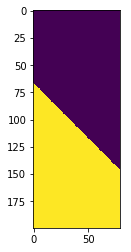

In [3]:
model = 1 + np.tri(depth, length, -depth//3, dtype=int)

plt.imshow(model)
plt.show()

In [4]:
model[100]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Now set the upper part of the model — above the wedge — to zero (blue).

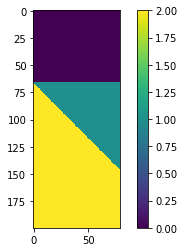

In [5]:
model[:depth//3,:] = 0

plt.imshow(model)
plt.colorbar()
plt.show()

If this model looks funny, we can change its parameters, or get fancy with plotting to achieve more or less whatever dimensions we like.

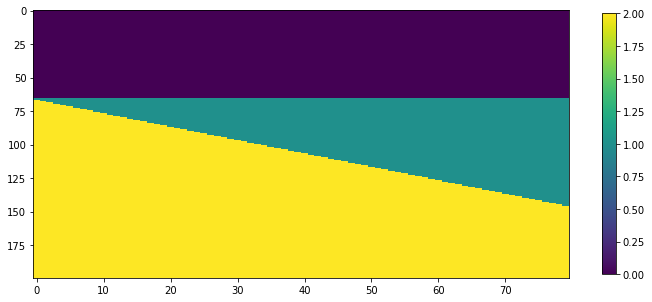

In [6]:
plt.figure(figsize=(12, 6))
plt.imshow(model, aspect=0.2)
plt.colorbar(shrink=0.8)
plt.show()

Now we can make some Vp-rho pairs (rock 0 and rock 1).

In [7]:
rocks = np.array([[2700, 2750],
                  [2400, 2450],
                  [2800, 3000]])

I was using np.take here, but 'fancy indexing' is shorter and more intuitive. We are just going to index rocks using the integers in model. That is, if model has a 1, we take the second element, [2400, 2450], from rocks. We'll end up with an array containing the rocks corresponding to each element of earth.

In [8]:
earth = rocks[model]

Now apply `np.product` to those Vp-rho pairs to get impedance at every sample.

In [9]:
imp = np.apply_along_axis(np.product, -1, earth)

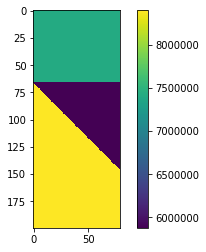

In [10]:
plt.imshow(imp)
plt.colorbar()

## Model seismic reflections

Now we have an earth model — giving us acoustic impedance everywhere in this 2D grid — we define a function to compute reflection coefficients for every trace.

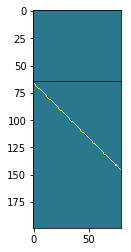

In [11]:
def make_rc(imp):
    upper = imp[ :-1, :]
    lower = imp[1:  , :]
    
    return (lower - upper) / (lower + upper)

rc = make_rc(imp)

plt.imshow(rc, aspect=1)
plt.show()

We'll use `scipy.signal.ricker` to make a wavelet:

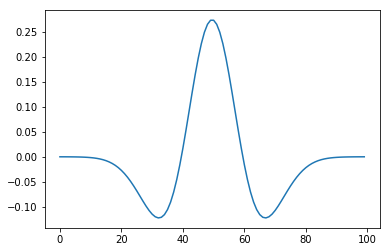

In [12]:
from scipy.signal import ricker

f = 25
wavelet = ricker(100, 1000/(4*f))

plt.plot(wavelet)
plt.show()

IF you have `bruges`, you might prefer the following. (To get `bruges`, go to your terminal, activate the current environment, and type `pip install bruges`. Then restart this kernel and re-run this notebook.)

In [13]:
# import bruges
# wavelet = bruges.filters.ricker(duration=0.1, dt=0.001, f=60)

# plt.plot(wavelet)
# plt.show()

Now apply 1D convolution to every trace:

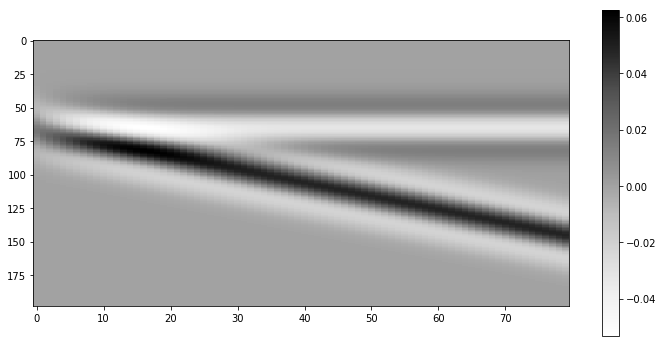

In [15]:
def convolve(trace):
    return np.convolve(trace, wavelet, mode='same')

synth = np.apply_along_axis(convolve,
                            axis=0,
                            arr=rc)

plt.figure(figsize=(12,6))
plt.imshow(synth, cmap="Greys", aspect=0.2)
plt.colorbar()
plt.show()

## Measure amplitude at the peak

In [16]:
apparent = np.amin(synth, axis=0)
t_apparent = np.argmin(synth, axis=0)

actual = synth[depth//3, :]
t_actual = np.ones_like(t_apparent) * depth//3

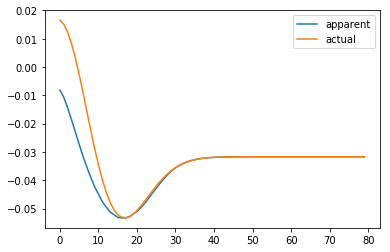

In [17]:
plt.plot(apparent, label="apparent")
plt.plot(actual, label="actual")
plt.legend()
plt.show()

In [18]:
# t_apparent = t_apparent.astype(np.float)
# t_apparent[0] = np.nan

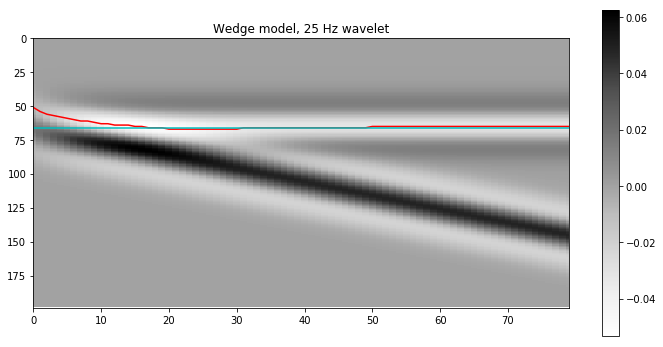

In [19]:
plt.figure(figsize=(12,6))

# Plot seismic
plt.imshow(synth, cmap="Greys", aspect=0.2)
plt.colorbar()

# Plot horizons
plt.plot(t_apparent, 'r')
plt.plot(t_actual, 'c')

plt.xlim([0, 79])
plt.ylim([199, 0])
plt.title("Wedge model, {} Hz wavelet".format(f))
plt.show()

## Find the tuning thickness

We can find the thickness at which the amplitude peak starts... this is called the tuning thickness. 

In [20]:
tuning = np.argmin(actual)
vp = 2400
wavelength = 2 * 1000 * (vp / f) / vp  # in milliseconds TWT

print("Tuning thickness is {:.1f} ms, or 1/{:.1f} wavelength".format(tuning, wavelength/tuning))

Tuning thickness is 17.0 ms, or 1/4.7 wavelength


## A 'real' model

Let's define a model using a PNG image...

In [ ]:
import matplotlib as mpl

img = mpl.image.imread('./data/Hubbard_etal_2014.png')
meanimg = np.mean(img, axis=-1)
model = np.digitize(meanimg, bins=[0.5, 0.6, 0.7, 0.8])

In [ ]:
np.unique(model)

So now we need 5 rocks in the `rocks` array. Run this, then go back to the fancy indexing line (`earth = rocks[model]`) and re-run it the code blocks that follow it.

In [ ]:
rocks = np.array([[2600, 2700],
                  [2700, 2750],
                  [2400, 2450],
                  [2550, 2650],
                  [2800, 3000]])

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2016</p>
</div>